In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from ultralytics import YOLO
from models import get_transfer_learning_resnet50
from loaders import get_loaders
from train import train

c:\Users\sharm\Python Projects\Research Papers\Cattle Muzzle Identification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
img_width = 224
img_height = 224
batch_size = 64
num_classes = 300
lr = 0.0001

In [3]:
root_dir = 'cattle muzzle'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO('yolov10_fine_tuned.pt').to(device)
device

device(type='cuda')

In [4]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((img_width, img_height))
])


train_loader, val_loader = get_loaders(root_dir = root_dir, 
                                       model = yolo_model, 
                                       batch_size = batch_size, 
                                       train_ratio=0.5,
                                       transform = transform)


In [5]:
clf_model = get_transfer_learning_resnet50(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=lr)
num_epochs = 25


Epoch 1/25
Training batch 1/23
Training batch 2/23
Training batch 3/23
Training batch 4/23
Training batch 5/23
Training batch 6/23
Training batch 7/23
Training batch 8/23
Training batch 9/23
Training batch 10/23
Training batch 11/23
Training batch 12/23
Training batch 13/23
Training batch 14/23
Training batch 15/23
Training batch 16/23
Training batch 17/23
Training batch 18/23
Training batch 19/23
Training batch 20/23
Training batch 21/23
Training batch 22/23
Training batch 23/23
Validation batch 1/23
Validation batch 2/23
Validation batch 3/23
Validation batch 4/23
Validation batch 5/23
Validation batch 6/23
Validation batch 7/23
Validation batch 8/23
Validation batch 9/23
Validation batch 10/23
Validation batch 11/23
Validation batch 12/23
Validation batch 13/23
Validation batch 14/23
Validation batch 15/23
Validation batch 16/23
Validation batch 17/23
Validation batch 18/23
Validation batch 19/23
Validation batch 20/23
Validation batch 21/23
Validation batch 22/23
Validation batch 

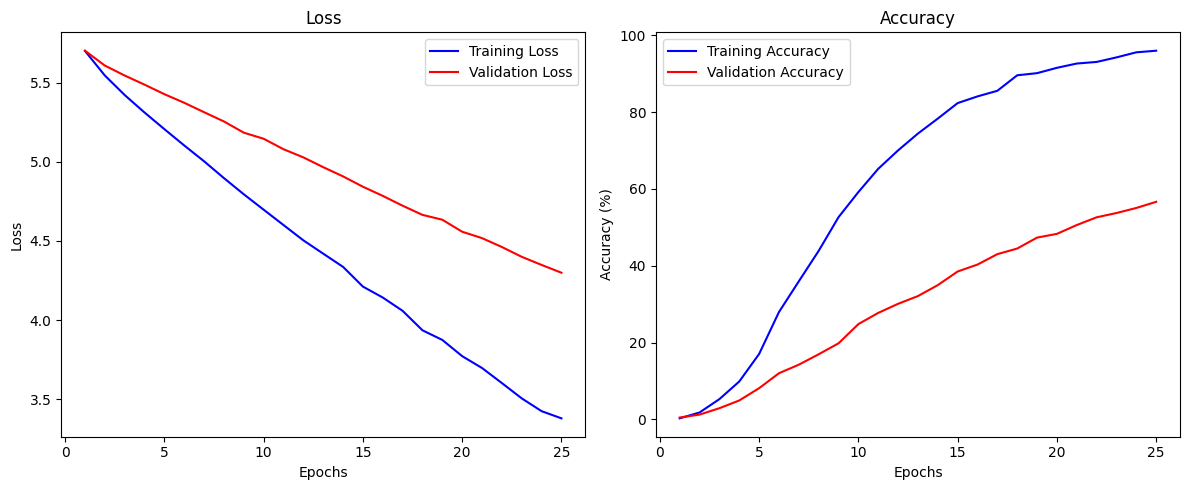

In [6]:
train(clf_model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

In [7]:
torch.save(clf_model, 'resnet_transfer_learning.pth')

In [8]:
from PIL import Image

def inference(img_path, transform, yolo_model, clf_model, device):
    img = Image.open(img_path)
    img_tensor = transform(img)

    results = yolo_model(img_tensor)  

    if len(results) > 0:
        bbox = results[0].boxes.xyxy[0] 

        xmin, ymin, xmax, ymax = map(int, bbox)
        cropped_img = img.crop((xmin, ymin, xmax, ymax))

        cropped_img_tensor = transform(cropped_img)
        cropped_img_tensor = cropped_img_tensor.to(device)
        cropped_img_tensor = cropped_img_tensor.unsqueeze(0) 

        output = clf_model(cropped_img_tensor)
        return torch.argmax(output).item()

In [9]:
img_path = r'cattle muzzle\069\IMG_0906.JPG'
transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((img_width, img_height))
])
yolo_model = YOLO('yolov10_fine_tuned.pt')
clf_model = torch.load('resnet_transfer_learning.pth')
print(inference(img_path, transform, yolo_model, clf_model, device))


WARNING  torch.Tensor inputs should be BCHW i.e. shape(1, 3, 640, 640) divisible by stride 32. Input shape(3, 224, 224) is incompatible.
0: 224x224 1 muzzle, 41.9ms
Speed: 0.0ms preprocess, 41.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
220
